####  Information-Based Learning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, Image

%matplotlib inline

In [2]:
%%html 
<style>
table {float:left; border-style: solid;}
</style>

In [3]:
# importing the dataset
data_path = 'data/'
file_name = 'titanic_clean_df.csv'
titanic_df = pd.read_csv(data_path+file_name)
display(titanic_df.shape)
titanic_df.info()
titanic_df.head()

(891, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Salutation   891 non-null    object 
 13  FamilySize   891 non-null    int64  
 14  FareBand     891 non-null    object 
 15  AgeBand      891 non-null    object 
 16  FSizeBand    891 non-null    object 
dtypes: float64(2), int64(6), object(9)
memory usage: 118.5+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,FamilySize,FareBand,AgeBand,FSizeBand
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,"(-0.001, 7.91]","(21.0, 29.0]",small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,"(31.0, 512.329]","(36.75, 80.0]",small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,"(7.91, 14.454]","(21.0, 29.0]",alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,"(31.0, 512.329]","(29.0, 36.75]",small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,"(7.91, 14.454]","(29.0, 36.75]",alone


#### Encoding categorical variables

Facts:
- sklearn's DecisionTreeClassifier requires numeric features ("*Decision tress are able to handle both numerical and categorical data. However scikit-learn implementation does not support categorical variables for now*").
- Similarly, sklearn's RandomForestClassifier, AdaBoostClassifier, and GradientBoostingClassifier do not support categorical features; hence, mapping them to numeric features is required.

Concerns:
- I am considering ordinal encoding and/or one-hot-encoding. After reading different articles about the impact of these approaches on tree-based algorithms, the conclusion is that each has pros and cons, and people usually try multiple approaches and compare the performance.
- Ordinal encoding will make the model treat the features as numeric, this might be a problem when there is no order. Also, this might lead to 'crazy' splits like 'x<1.5' for a feature that only takes [1,2,3] for example.
- Regarding one-hot-encoding, this approach might make it harder to interpret the trees since features are treated independently; it might also affect feature importance.

There are categorical variables where an order is evident; for example, in FareBand (-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]. For others, such as Sex and Salutation, there is no order. I will try both encoding approaches where appropriate to experiment and compare.

In [4]:
titanic_df['FareBand'] = titanic_df['FareBand'].astype('category')
titanic_df['AgeBand'] = titanic_df['AgeBand'].astype('category')

In [5]:
# encoding categorical variables
encoded_df = titanic_df.copy()

# embarked
encoded_df['Embarked'] = encoded_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# salutation
title_mapping = {"Mr": 0, "Master": 1, "Other_M": 2, "Mrs": 3, "Miss": 4, "Other_F": 5}
encoded_df['Salutation'] = encoded_df['Salutation'].map(title_mapping)

# fare band
fare_mapping = {encoded_df.FareBand.cat.categories[0]:1, encoded_df.FareBand.cat.categories[1]:2, encoded_df.FareBand.cat.categories[2]:3, encoded_df.FareBand.cat.categories[3]:4}
encoded_df['FareBand'] = encoded_df['FareBand'].map(fare_mapping).astype(int)

# age band
age_mapping = {encoded_df.AgeBand.cat.categories[0]:1, encoded_df.AgeBand.cat.categories[1]:2, encoded_df.AgeBand.cat.categories[2]:3, encoded_df.AgeBand.cat.categories[3]:4}
encoded_df['AgeBand'] = encoded_df['AgeBand'].map(age_mapping).astype(int)
 
# family size
family_mapping = {"alone": 1, "small": 2, "medium": 3, "large": 4}
encoded_df['FSizeBand'] = encoded_df['FSizeBand'].map(family_mapping)

# sex
encoded_df['Sex'] = encoded_df['Sex'].map({'male': 0, 'female': 1})

encoded_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,FamilySize,FareBand,AgeBand,FSizeBand
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,1,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,3,1,3,4,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,4,0,4,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,3,1,3,3,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,0,4,3,1


Text(0.5, 1.0, 'Correlation of Features')

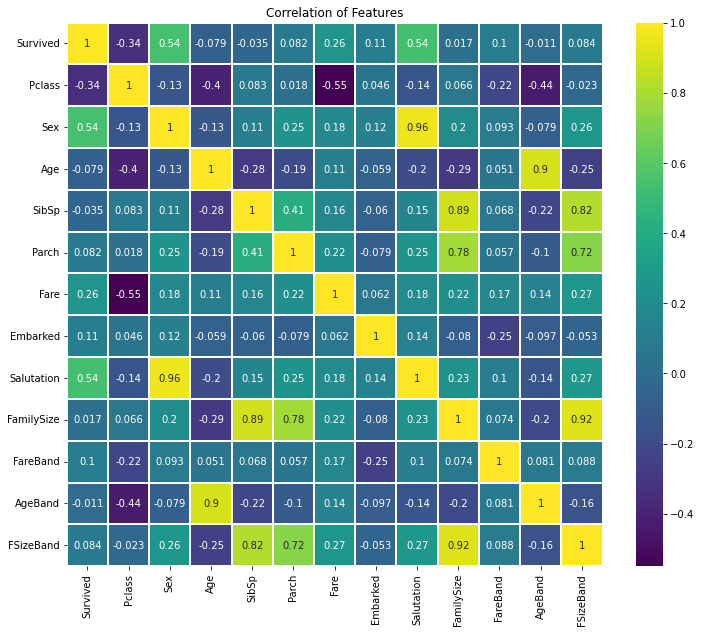

In [6]:
# correlation
plt.figure(figsize=(12,10))
sns.heatmap(encoded_df.drop(columns=['PassengerId']).corr(), cmap='viridis', linewidths=0.1, vmax=1.0, linecolor='white', annot=True).set_title('Correlation of Features')

- Sex and Salutation have the same correlation with the target which is positive (0.54).
- Pclass has a negative moderate correlation to the target at -0.34.
- Embarked has a low correlation with the target (0.11)
- The age-related features Age and AgeBand have really low correlation with Survived at <-0.09.
- Similarly, family-related features (SibSp, Parch, Family Size and FSizeBand) have less than 0.1 of correlation score.
- FareBand has a relatively moderate correlation with Survived at 0.3.

Based on the the analysis performed, I will drop the following features:
- PassengerId: no needed for modelling.
- Name: is not useful as it is. It was use for feature engineering (Salutation) and now can be dropped.
- Age: I already transformed it into a new feature, AgeBand. I am not expecting *AgeBand* to be a good predictor during modelling, its correlation with the target is very low. However, I will include it to then analyze the models' feature importance.
- SibSp, Parch, FamilySize: SibSp and Parch were "combined" into FamilySize, and the latter was transofrmed into FSizeBand, they can be now dropped.
- Ticket and Cabin.
- Fare: used to create FareBand.
- Embarked: Honestly, I don think that the chances of surviving were determined by the port where people embarked at, and data shows that its correlation with Survived is low, and at some ports the proportion of 1st class passengers is significant, suggesting that even that low correlation might be determined by Pclass. *NOTE: I even included Embarked in exploratory models and found that models actually performed better without it*.
- Sex: it has the same correlation than Salutation, and it was proven that the latter includes the gender. I explored it, and Salutation provides better results than Sex.

I will use the remaining features for modelling and see what models have to say about the feature importance.

In [7]:
# dropping unneeded columns
encoded_df = encoded_df.drop(columns=['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'FamilySize', 'Sex', 'Embarked'])
encoded_df.head()

,Survived,Pclass,Salutation,FareBand,AgeBand,FSizeBand
0,0,3,0,1,2,2
1,1,1,3,3,4,2
2,1,3,4,4,2,1
3,1,1,3,3,3,2
4,0,3,0,4,3,1


In [8]:
encoded_df.to_csv('data/titanic_preproc_df.csv', index=False)
titanic_df.to_csv('data/titanic_clean_df.csv', index=False)

Version of the data where Salutation is encoded using one-hot-encoding:

In [9]:
df_ohe = encoded_df.copy()

# there is no ordinal order for Salutation, let's try one-hot-encoding with that feature
df_ohe.Salutation = titanic_df.Salutation

df_ohe = pd.get_dummies(data=df_ohe, columns=['Salutation'])
df_ohe.head()

,Survived,Pclass,FareBand,AgeBand,FSizeBand,Salutation_Master,Salutation_Miss,Salutation_Mr,Salutation_Mrs,Salutation_Other_F,Salutation_Other_M
0,0,3,1,2,2,0,0,1,0,0,0
1,1,1,3,4,2,0,0,0,1,0,0
2,1,3,4,2,1,0,1,0,0,0,0
3,1,1,3,3,2,0,0,0,1,0,0
4,0,3,4,3,1,0,0,1,0,0,0


___
### Models

#### Decision Trees

#### Training

CPU times: user 1.82 ms, sys: 1.12 ms, total: 2.94 ms
Wall time: 6.3 ms


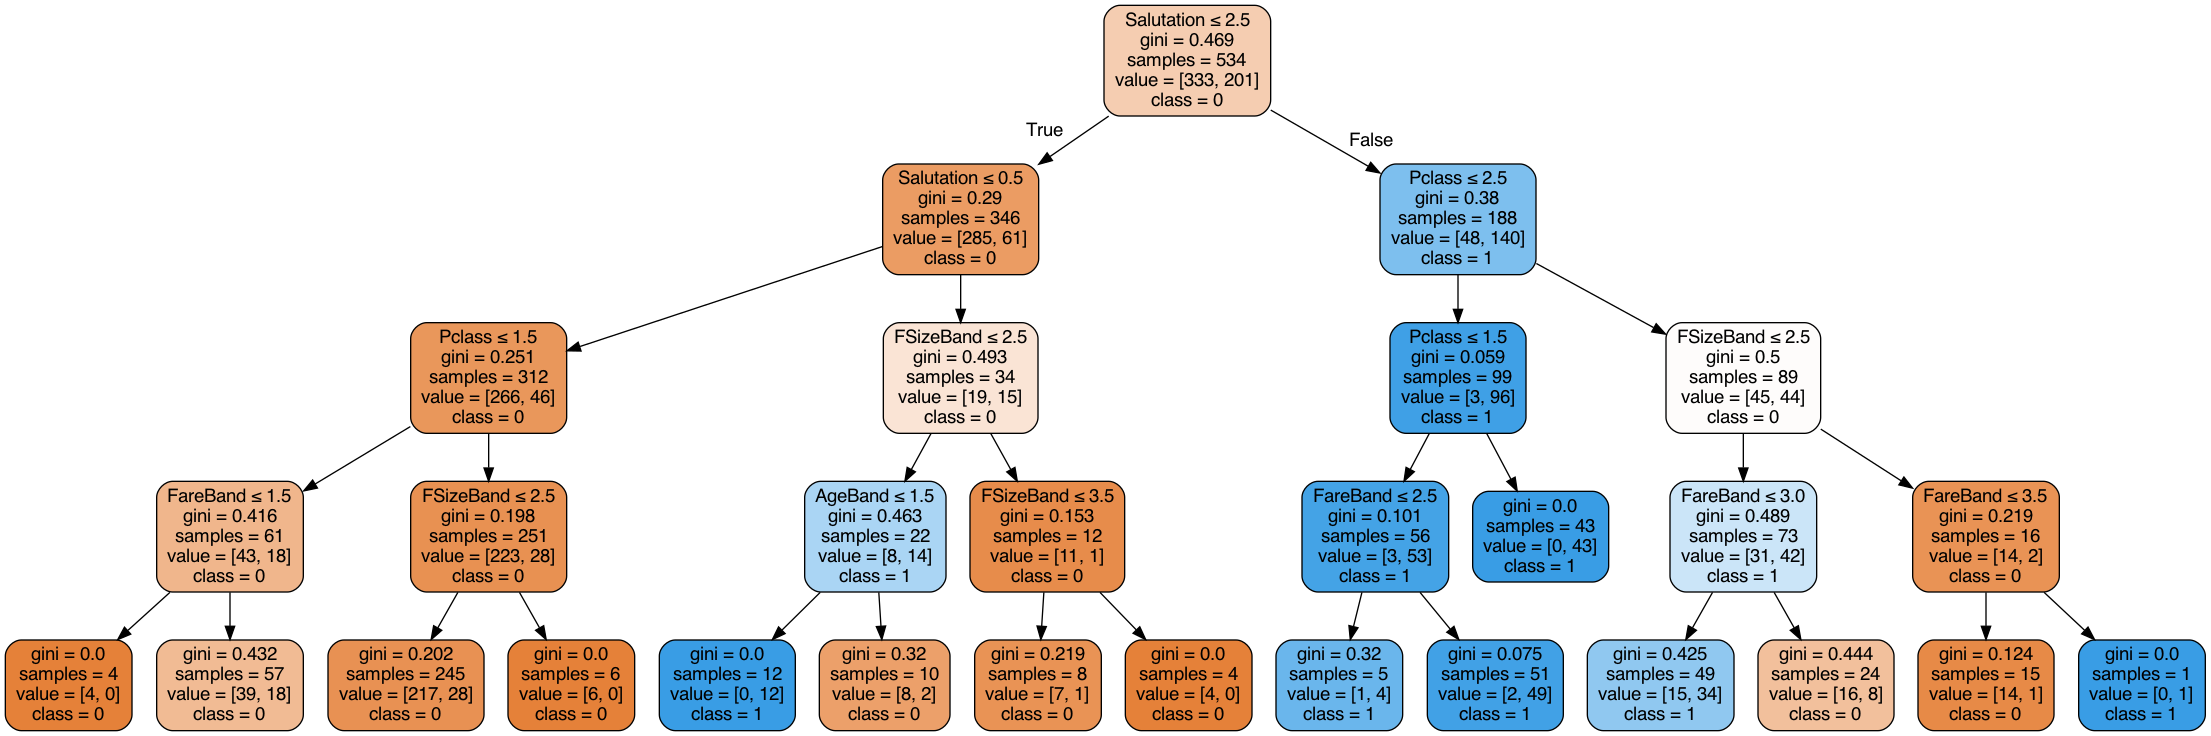

#### Execution Time - Classification

CPU times: user 1.08 ms, sys: 913 µs, total: 1.99 ms
Wall time: 2.23 ms


#### Model in Test Data

Accuracy: 0.8179


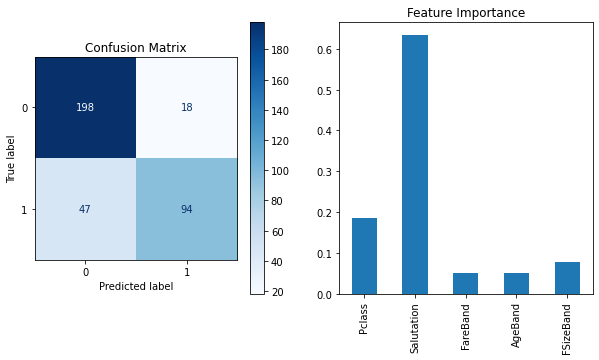

#### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       216
           1       0.84      0.67      0.74       141

    accuracy                           0.82       357
   macro avg       0.82      0.79      0.80       357
weighted avg       0.82      0.82      0.81       357



In [10]:
# split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = encoded_df[features], encoded_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
dtc = DecisionTreeClassifier(max_depth=4) # criterion=gini by default
%time dtc.fit(X_train, y_train)

# plotting the decision tree
dot_data = export_graphviz(dtc, out_file=None, 
                     feature_names=X.columns.to_list(),  
                     class_names=['0','1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = "png"
graph.render('tree')
display(Image('tree.png', width=1500))

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = dtc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'hspace': 0.3})
label_class_set = dtc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# feature importance
feature_names = X.columns.to_list()
feature_importances = pd.Series(dtc.feature_importances_, index=feature_names)
feature_importances.plot(kind='bar', ax=ax[1])
ax[1].set_title("Feature Importance")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

<u>Using one-hot-encoding</u>

Applying same algorithm in the other version of the dataset.

#### Training

CPU times: user 1.64 ms, sys: 298 µs, total: 1.94 ms
Wall time: 1.83 ms


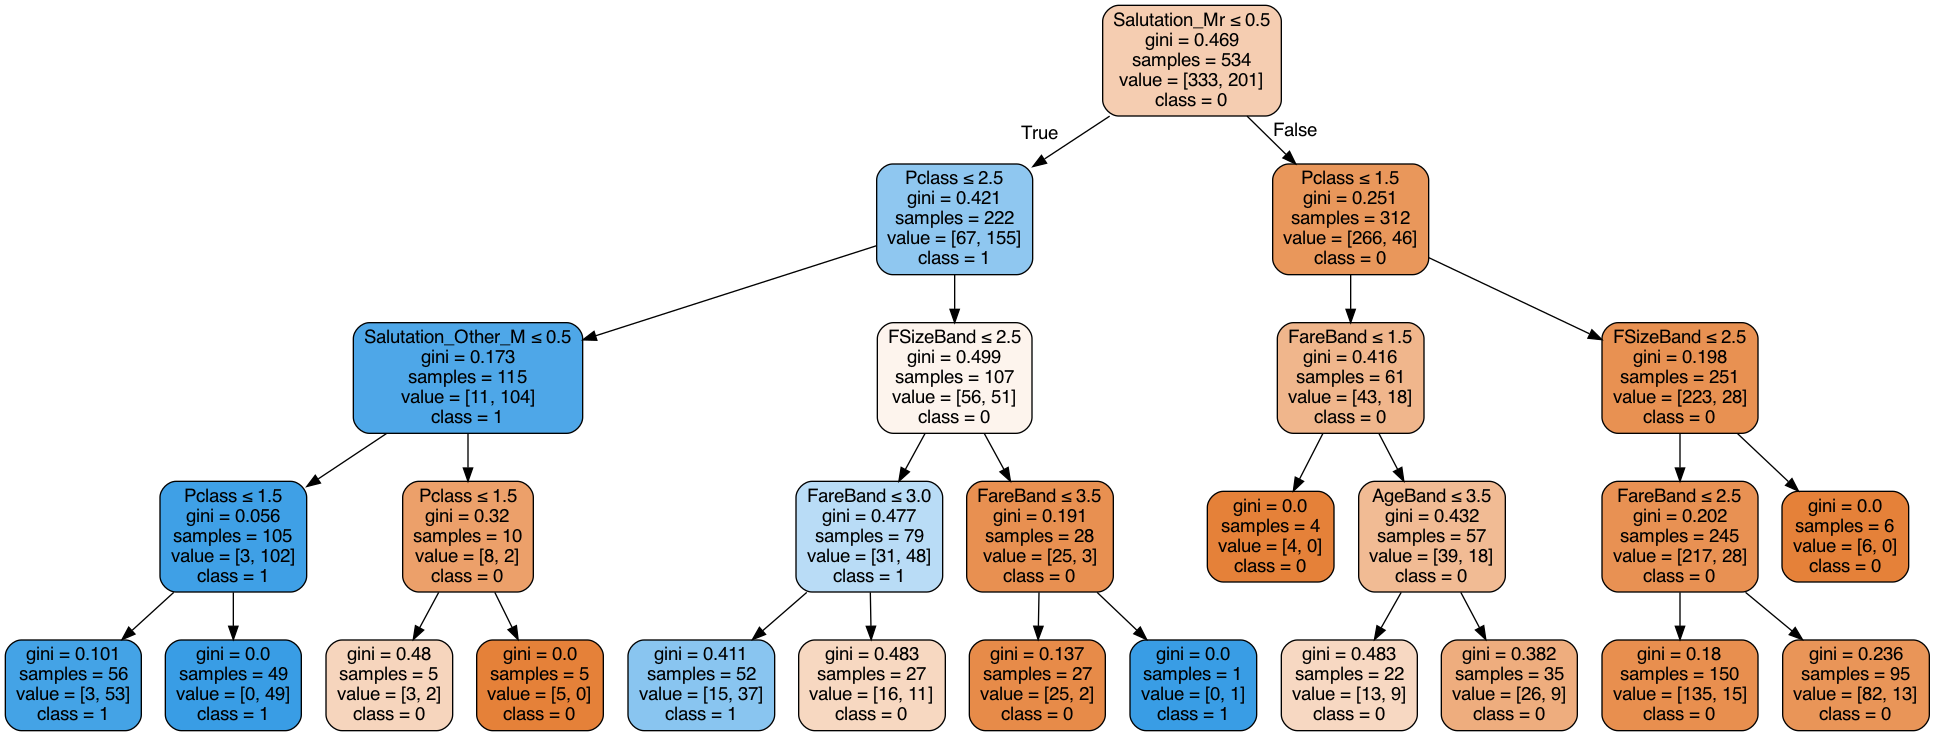

#### Execution Time - Classification

CPU times: user 1.34 ms, sys: 938 µs, total: 2.28 ms
Wall time: 2.18 ms


#### Model in Test Data

Accuracy: 0.8151


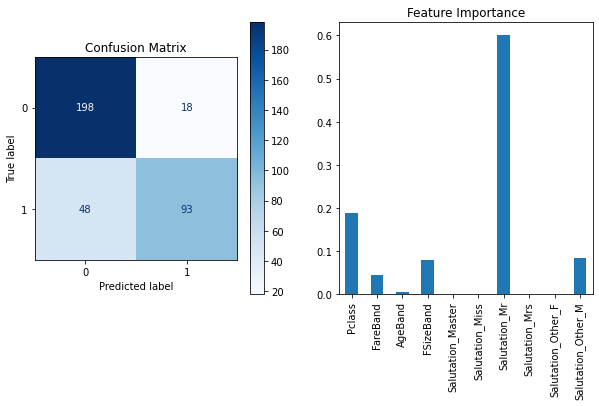

#### Classification Report

              precision    recall  f1-score   support

           0       0.80      0.92      0.86       216
           1       0.84      0.66      0.74       141

    accuracy                           0.82       357
   macro avg       0.82      0.79      0.80       357
weighted avg       0.82      0.82      0.81       357



In [11]:
# split into training and test part
X, y = df_ohe.drop(columns=['Survived']), df_ohe['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
dtc = DecisionTreeClassifier(max_depth=4) # criterion=gini by default
%time dtc.fit(X_train, y_train)

# plotting the decision tree
dot_data = export_graphviz(dtc, out_file=None, 
                     feature_names=X.columns.to_list(),  
                     class_names=['0','1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph.format = "png"
graph.render('tree')
display(Image('tree.png', width=1200))

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = dtc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'hspace': 0.3})
label_class_set = dtc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# feature importance
feature_names = X.columns.to_list()
feature_importances = pd.Series(dtc.feature_importances_, index=feature_names)
feature_importances.plot(kind='bar', ax=ax[1])
ax[1].set_title("Feature Importance")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

Observations:
- I trained two Decision Tree models using two versions of the dataset. For both the accuracy was ~83.19%.
- Accuracy scores varied with the max_depth parameter; in my case, when max_depth=4 the model performed better (tested with max_depth between 1 and 10).
- There was no difference in acuracy between the model trained on both versions of the data set. However, interpreting the features importance is more difficult in the data set where Salutation was encoded using the one-hot-encoding approach.
- For the 1st model:
    - When the model predicts a positive outcome, it is correct ~83% (precision) of the time.
    - From the total of instances with a true positive outcome, the model classifies them correctly ~72% (recall) of the time.

#### Random Forests

#### Training

CPU times: user 72.4 ms, sys: 1.66 ms, total: 74.1 ms
Wall time: 74.5 ms


#### Execution Time - Classification

CPU times: user 8.08 ms, sys: 449 µs, total: 8.53 ms
Wall time: 8.43 ms


#### Model in Test Data

Accuracy: 0.8207


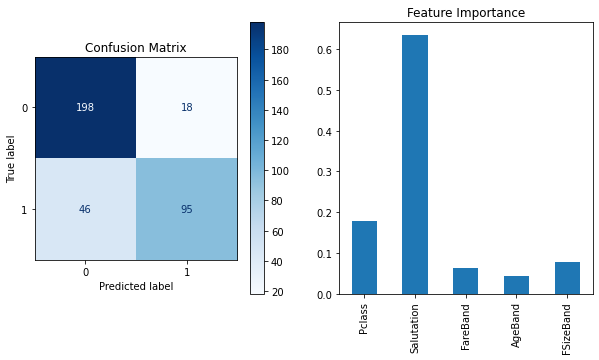

#### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       216
           1       0.84      0.67      0.75       141

    accuracy                           0.82       357
   macro avg       0.83      0.80      0.80       357
weighted avg       0.82      0.82      0.82       357



In [12]:
# split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = encoded_df[features], encoded_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
rfc =  RandomForestClassifier(max_depth=4, random_state=42) # criterion=gini by default
%time rfc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = rfc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'hspace': 0.3})
label_class_set = rfc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# feature importance
feature_names = X.columns.to_list()
feature_importances = pd.Series(rfc.feature_importances_, index=feature_names)
feature_importances.plot(kind='bar', ax=ax[1])
ax[1].set_title("Feature Importance")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

<u>Using one-hot-encoding</u>

#### Training

CPU times: user 70 ms, sys: 1.08 ms, total: 71.1 ms
Wall time: 71.1 ms


#### Execution Time - Classification

CPU times: user 7.82 ms, sys: 345 µs, total: 8.16 ms
Wall time: 8.09 ms


#### Model in Test Data

Accuracy: 0.8207


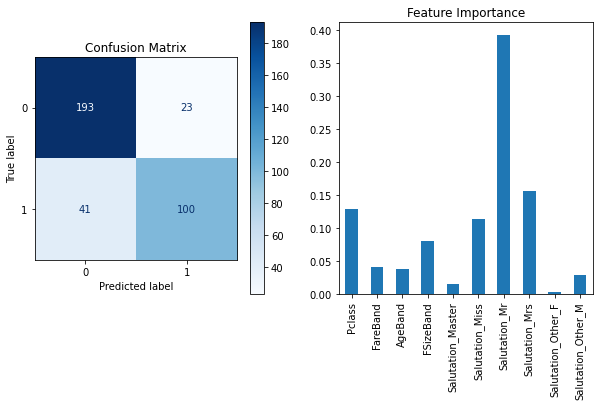

#### Classification Report

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       216
           1       0.81      0.71      0.76       141

    accuracy                           0.82       357
   macro avg       0.82      0.80      0.81       357
weighted avg       0.82      0.82      0.82       357



In [13]:
# split into training and test part
X, y = df_ohe.drop(columns=['Survived']), df_ohe['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
rfc =  RandomForestClassifier(max_depth=4, random_state=42) # criterion=gini by default
%time rfc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = rfc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'hspace': 0.3})
label_class_set = rfc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# feature importance
feature_names = X.columns.to_list()
feature_importances = pd.Series(rfc.feature_importances_, index=feature_names)
feature_importances.plot(kind='bar', ax=ax[1])
ax[1].set_title("Feature Importance")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

Observations:
- I trained two Random Forest models using two versions of the dataset. For the first one, the accuracy is 83.19%, and for the one where Salutation was one-hot-encoded the accuracy was ~82.63%.
- Accuracy scores varied with the max_depth parameter; in my case, when max_depth=4 the models performed better (tested with max_depth between 1 and 10).
- For the first model:
    - When the model predicts a positive outcome, it is correct ~83% (precision) of the time.
    - From the total of instances with a true positive outcome, the model classifies them correctly ~72% (recall) of the time.

#### AdaBoost

#### Training

CPU times: user 39.3 ms, sys: 1.17 ms, total: 40.5 ms
Wall time: 39.9 ms


#### Execution Time - Classification

CPU times: user 6.37 ms, sys: 573 µs, total: 6.94 ms
Wall time: 6.81 ms


#### Model in Test Data

Accuracy: 0.8403


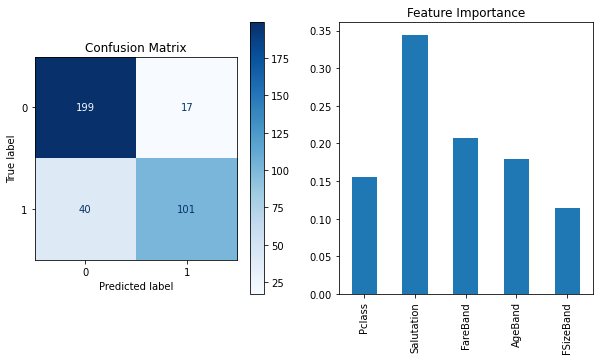

#### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       216
           1       0.86      0.72      0.78       141

    accuracy                           0.84       357
   macro avg       0.84      0.82      0.83       357
weighted avg       0.84      0.84      0.84       357



In [14]:
# split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = encoded_df[features], encoded_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
abc =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=2)) # the estimator is DecisionTreeClassifier initialized with max_depth=1 by default
%time abc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = abc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'hspace': 0.3})
label_class_set = abc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# feature importance
feature_names = X.columns.to_list()
feature_importances = pd.Series(abc.feature_importances_, index=feature_names)
feature_importances.plot(kind='bar', ax=ax[1])
ax[1].set_title("Feature Importance")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

<u>Using one-hot-encoding</u>

#### Training

CPU times: user 39.9 ms, sys: 1.31 ms, total: 41.2 ms
Wall time: 40.7 ms


#### Execution Time - Classification

CPU times: user 6.35 ms, sys: 463 µs, total: 6.81 ms
Wall time: 6.81 ms


#### Model in Test Data

Accuracy: 0.8375


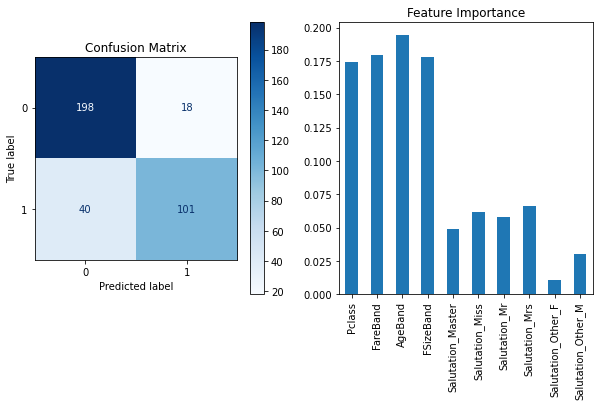

#### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       216
           1       0.85      0.72      0.78       141

    accuracy                           0.84       357
   macro avg       0.84      0.82      0.82       357
weighted avg       0.84      0.84      0.83       357



In [15]:
# split into training and test part
X, y = df_ohe.drop(columns=['Survived']), df_ohe['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
abc =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=2)) # the estimator is DecisionTreeClassifier initialized with max_depth=1 by default
%time abc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = abc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'hspace': 0.3})
label_class_set = abc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# feature importance
feature_names = X.columns.to_list()
feature_importances = pd.Series(abc.feature_importances_, index=feature_names)
feature_importances.plot(kind='bar', ax=ax[1])
ax[1].set_title("Feature Importance")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

Observations:
- I trained two AdaBoost models using two versions of the dataset. For the first one, the accuracy is 83.75%, and for the one where Salutation was one-hot-encoded the accuracy was ~83.19%.
- Accuracy scores varied with the max_depth parameter; in my case, when max_depth=2 in the default classifier (Decision Trees) the models performed better (tested with max_depth between 1 and 10).
- For the first model:
    - When the model predicts a positive outcome, it is correct ~85% (precision) of the time.
    - From the total of instances with a true positive outcome, the model classifies them correctly ~72% (recall) of the time.

#### Gradient Boosting

#### Training

CPU times: user 30.3 ms, sys: 1.25 ms, total: 31.5 ms
Wall time: 31.4 ms


#### Execution Time - Classification

CPU times: user 1.65 ms, sys: 316 µs, total: 1.97 ms
Wall time: 2.52 ms


#### Model in Test Data

Accuracy: 0.8459


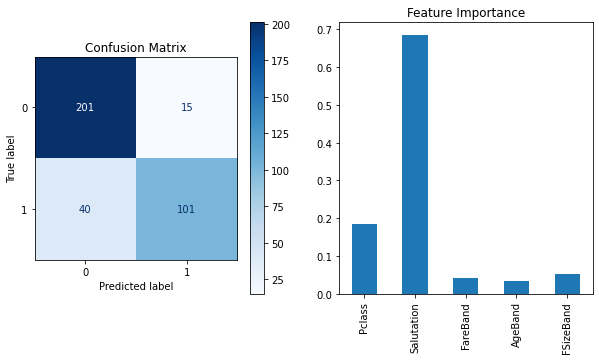

#### Classification Report

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       216
           1       0.87      0.72      0.79       141

    accuracy                           0.85       357
   macro avg       0.85      0.82      0.83       357
weighted avg       0.85      0.85      0.84       357



In [16]:
# split into training and test part
features = ['Pclass', 'Salutation', 'FareBand', 'AgeBand', 'FSizeBand']
X, y = encoded_df[features], encoded_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
# learning_rate is initially 0.1 by default, but I got better results with 0.7 nd max_depth=2
gbc =  GradientBoostingClassifier(learning_rate=0.8, max_depth=2) # criterion=friedman_mse by default
%time gbc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = gbc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'hspace': 0.3})
label_class_set = gbc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# feature importance
feature_names = X.columns.to_list()
feature_importances = pd.Series(gbc.feature_importances_, index=feature_names)
feature_importances.plot(kind='bar', ax=ax[1])
ax[1].set_title("Feature Importance")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

<u>Using one-hot-encoding</u>

#### Training

CPU times: user 35.3 ms, sys: 1.33 ms, total: 36.6 ms
Wall time: 44.5 ms


#### Execution Time - Classification

CPU times: user 1.26 ms, sys: 52 µs, total: 1.31 ms
Wall time: 1.29 ms


#### Model in Test Data

Accuracy: 0.8151


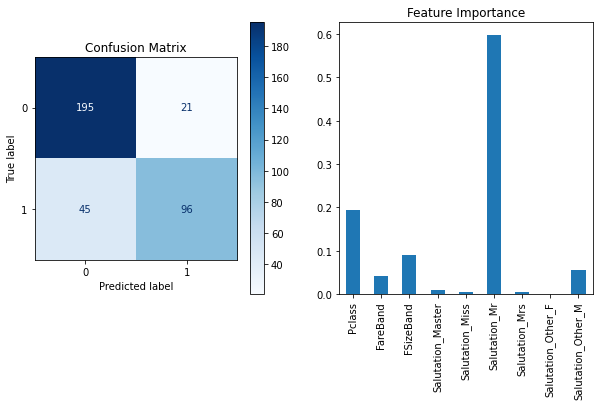

#### Classification Report

              precision    recall  f1-score   support

           0       0.81      0.90      0.86       216
           1       0.82      0.68      0.74       141

    accuracy                           0.82       357
   macro avg       0.82      0.79      0.80       357
weighted avg       0.82      0.82      0.81       357



In [17]:
# split into training and test part
X, y = df_ohe.drop(columns=['Survived', 'AgeBand']), df_ohe['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# training
display(Markdown("#### Training"))
# learning_rate is 0.1 by default, but I got better results with 0.7
gbc =  GradientBoostingClassifier(learning_rate=0.7, max_depth=2) # criterion=friedman_mse by default
%time gbc.fit(X_train, y_train)

# predictions of label classes for the unseen test data
display(Markdown("#### Execution Time - Classification"))
%time predicted_Y_test = gbc.predict(X_test) # timing classification process

display(Markdown("#### Model in Test Data"))
# accuracy score
accuracy_test = metrics.accuracy_score(y_test, predicted_Y_test)
print('Accuracy:', '{:.4f}'.format(accuracy_test))

fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'hspace': 0.3})
label_class_set = gbc.classes_

# confusion matrix
cm_disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted_Y_test, labels=label_class_set, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix")

# feature importance
feature_names = X.columns.to_list()
feature_importances = pd.Series(gbc.feature_importances_, index=feature_names)
feature_importances.plot(kind='bar', ax=ax[1])
ax[1].set_title("Feature Importance")
plt.show()

# classification report
display(Markdown("#### Classification Report"))
print(metrics.classification_report(y_test, predicted_Y_test))

Observations:
- I trained two Gradient Boosting models using two versions of the dataset. For the first one, the accuracy is 84.59%, and for the one where Salutation was one-hot-encoded the accuracy was ~82.07%.
- Accuracy scores varied with the model parameters; in my case, when max_depth=2 and learning_rate=0.7 the models performed better (tested with max_depth between 1 and 10, and learning rate from 0.1 to 1).
- For the first model:
    - When the model predicts a positive outcome, it is correct ~87% (precision) of the time.
    - From the total of instances with a true positive outcome, the model classifies them correctly ~72% (recall) of the time.

### Models Comparison

**Performance summary**:

| Model             | Accuracy | Precision | Recall |
|-------------------|----------|-----------|--------|
| Decision Trees    |   83.19% |    83.00% | 72.00% |
| Random Forest     |   83.19% |    83.00% | 72.00% |
| AdaBoost          |   83.75% |    85.00% | 72.00% |
| Gradient Boosting |   84.59% |    87.00% | 72.00% |

<br><br><br><br><br><br><br>
- Decision Trees and Random Forest are tied in terms of accuracy at 83.19%, which was the lowest value for this metric.
- AdaBoost was the second best in terms of accuracy at 83.75%.
- Gradient Boosting achieved the highest accuracy at ~84.6%.
- For Decision Trees, there was no difference in accuracy between the two versions of the data set. On the other hand, accuracy was lower in the data set where *Salutation* was one-hot-encoded for the rest of the techniques.